In [17]:
import numpy as np
import random
import math

from collections import namedtuple, deque
from itertools import count


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#import Connect Four from other file
from CFGameLogic import ConnectFour 

In [18]:
#defines a class that is used to store the data we obtain during learning

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

#defines a class of DQN of fixed depth and matrix size
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()

        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256,128)
        self.layer4 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)



BATCH_SIZE = 1024 #128
GAMMA =  0.90
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.001
LR = 1e-6
device = torch.device("cpu")

#initializes the environment 
board = ConnectFour()
state = board.vect() 
n_actions = 7
n_observations = len(state) 

##initialize neural networks. policy_net will be optimized in each step and target_net will be soft updated from policy_net by the specified rate TAU

#initializes the network, optimizer and memory for player 1
policy_net_1 = DQN(n_observations, n_actions).to(device)
target_net_1 = DQN(n_observations, n_actions).to(device)
target_net_1.load_state_dict(policy_net_1.state_dict())

optimizer_1 = optim.AdamW(policy_net_1.parameters(), lr=LR, amsgrad=True)
memory_1 = ReplayMemory(50000)

#initializes the network, optimizer and memory for player 2
policy_net_2 = DQN(n_observations, n_actions).to(device)
target_net_2 = DQN(n_observations, n_actions).to(device)
target_net_2.load_state_dict(policy_net_2.state_dict())

optimizer_2 = optim.AdamW(policy_net_2.parameters(), lr=LR, amsgrad=True)
memory_2 = ReplayMemory(50000)


steps_done = 0
def select_action(state,p, learn=True):
    global steps_done
    sample = random.random()
    eps_threshold =  EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if not learn:
        eps_threshold = 0
    if sample > eps_threshold:
        with torch.no_grad():
            #evaluates the network to obtain a vector for ALL moves
            if p==1:
                action_values = policy_net_1(state) 
            elif p==-1:
                action_values = policy_net_2(state)
            #selects the playable moves and returns the maximum as a tensor 
            max_index_nf =  torch.argmax(action_values[0,board.not_full()])
            return torch.tensor([[board.not_full()[max_index_nf]]], device=device, dtype=torch.long)
            #available_action_values = [action_values[i] for i in board.not_full()]
            #m = np.max(available_action_values)
            #return (action_values ==m).nonzero(as_tuple=False)
            #return torch.tensor([[np.argmax(available_action_values)]], device=device, dtype=torch.long) 
    else:
        r = random.choice(board.not_full())
        return torch.tensor([[r]], device=device, dtype=torch.long)




In [19]:
#minimizes the temporal difference error for player 1
def optimize_model_1():
    if len(memory_1) < BATCH_SIZE:
        return
    transitions = memory_1.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net_1(state_batch).gather(1, action_batch )

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device) 
    #with torch.no_grad():
    next_state_values[non_final_mask] = target_net_1(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    #criterion = nn.SmoothL1Loss()
    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer_1.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net_1.parameters(), 100)
    optimizer_1.step()

In [20]:
#minimizers the temporal difference error for player 2

def optimize_model_2():
    if len(memory_2) < BATCH_SIZE:
        return
    transitions = memory_2.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net_2(state_batch).gather(1, action_batch )

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device) 
    #with torch.no_grad():
    next_state_values[non_final_mask] = target_net_2(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    #criterion = nn.SmoothL1Loss()
    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    # Optimize the model

    optimizer_2.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net_2.parameters(), 100)
    optimizer_2.step()

In [21]:
num_episodes = 5000 
win1=0
win2=0
draw=0

#each i_episode corresponds to a single game of connect four while each t in count() corresponds to a single turn.
#There are no rewards unless the game ends. In that case a win yields +1, a defeat -1, and a draw 0.5.
for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    board.reset()
    state_1= board.vect()
    state_2= board.vect()
    state_1 = torch.tensor(state_1, dtype=torch.float32, device=device).unsqueeze(0)
    state_2 = torch.tensor(state_2, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        # Player 1
        played = False
        while not played:
            action_1  = select_action(state_1,board.whos_turn)
            observation, played, terminated = board.step(action_1.item())
       
        if terminated:
            next_state_1 = None
            next_state_2 = None
            reward_1 = torch.tensor([1], device=device) 
            reward_2 = torch.tensor([-1], device= device)
            memory_1.push(state_1, action_1, next_state_1, reward_1)
            memory_2.push(state_2,action_2,next_state_2, reward_2)
            win1 +=1
     
        else:
            reward_2 = torch.tensor([0], device=device)
            next_state_2 = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            if board.turn>1:
                memory_2.push(state_2,action_2,next_state_2, reward_2)
            # Player 2
            state_2 = next_state_2
            played = False
            while not played:
                action_2 = select_action(state_2, board.whos_turn)
                observation, played, terminated = board.step(action_2.item())
            if terminated and board.turn !=42:
                next_state_1 = None
                next_state_2 = None
                reward_1 = torch.tensor([-1], device=device)
                reward_2 = torch.tensor([1],device=device) 
                win2 +=1
                memory_1.push(state_1, action_1, next_state_1, reward_1)
                memory_2.push(state_2, action_2, next_state_2, reward_2)
               
            elif terminated and board.turn ==42:
                next_state_1 = None
                next_state_2 = None
                reward_1 = torch.tensor([0.5], device = device)
                reward_2 = torch.tensor([0.5], device = device)
                memory_1.push(state_1, action_1, next_state_1, reward_1)
                memory_2.push(state_2, action_2, next_state_2, reward_2)
                draw +=1
            else:
                next_state_1 = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
                reward_1 = torch.tensor([0],device=device)
            
                # Store the transition in memory and move to next state
                memory_1.push(state_1, action_1, next_state_1, reward_1)
                state_1 = next_state_1

                # Perform one step of the optimization (on the policy network)
        optimize_model_1()
        optimize_model_2()
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        #update model 1
        target_net_1_state_dict = target_net_1.state_dict()
        policy_net_1_state_dict = policy_net_1.state_dict()
        for key in policy_net_1_state_dict:
            target_net_1_state_dict[key] = policy_net_1_state_dict[key]*TAU + target_net_1_state_dict[key]*(1-TAU)
        target_net_1.load_state_dict(target_net_1_state_dict)
        #update model 2
        target_net_2_state_dict = target_net_2.state_dict()
        policy_net_2_state_dict = policy_net_2.state_dict()
        for key in policy_net_2_state_dict:
            target_net_2_state_dict[key] = policy_net_2_state_dict[key]*TAU + target_net_2_state_dict[key]*(1-TAU)
        target_net_2.load_state_dict(target_net_2_state_dict)
        if terminated: 
           break
    if i_episode%100==0 and i_episode >0:
        print(str(i_episode)+" episodes done.")
    

print('Complete')
print("Player 1 won " +str(win1) +" times.")
print("Player 2 won " +str(win2) +" times.")
print("There were " +str(draw) + " draws.")

0 episodes done.
100 episodes done.
200 episodes done.


KeyboardInterrupt: 

In [ ]:
torch.save(policy_net_1.state_dict(), "trained_1.pth")
torch.save(policy_net_2.state_dict(), "trained_2.pth")

In [ ]:
policy_net_1 = DQN(n_observations, n_actions).to(device)
policy_net_2 = DQN(n_observations, n_actions).to(device)
policy_net_1.load_state_dict(torch.load("trained_1_5000eps.pth"))
policy_net_2.load_state_dict(torch.load("trained_2_5000eps.pth"))


<All keys matched successfully>

In [ ]:
#defines a class the represents a player that chooses moves based on the trained model
class trainedPlayer():

    def __init__(self, ran):
        self.random = ran

    def play(self,board):
        state = torch.tensor(board.vect(), dtype=torch.float).unsqueeze(0)
        if board.whos_turn==1:
            action = select_action(state, 1, self.random).item()
        if board.whos_turn==-1:
            action = select_action(state,-1, self.random).item()
        return board.step(action)


In [ ]:
#Checks performence of the trained player against a random player

from CFPlayer import randomPlayer, alphaBetaPlayer

winsPlayer1= 0
winsPlayer2= 0
draws = 0
Player2 = trainedPlayer(True) 
Player1 = randomPlayer() 

for i in range(1000):
    board = ConnectFour()
    for t in count():
        done = Player1.play(board)[2]

        if done:
            winsPlayer1 +=1
            break
        done = Player2.play(board)[2]

        if done:
            if board.check_win(2):
                winsPlayer2 +=1
                break
            else:
                draws +=1
                break

print(winsPlayer1)
print(winsPlayer2)
print(draws)        



224
776
0


In [ ]:
Player1 = trainedPlayer(ran =True)
#note that we have to allow player 1 to sometimes choose a random action. Otherwise every game would play out the same.
number_of_games = 200
max_depth =4
number_of_wins_Player1 =[]
for d in range(1,max_depth+1):
    #initializes a player with alpha-beta pruning of depth d
    Player2 = alphaBetaPlayer(d)
    winsPlayer1 =0 
    for i in range(number_of_games):
        board = ConnectFour()
        for t in count():
            done = Player1.play(board)[2]

            if done:
                winsPlayer1 +=1
                break
            done = Player2.play(board)[2]

            if done:
                if board.check_win(2):
                    break
                else:
                    break   
    number_of_wins_Player1.append(winsPlayer1)

number_of_wins_Player1 = [element/number_of_games *100 for element in winsPlayer1]

KeyboardInterrupt: 

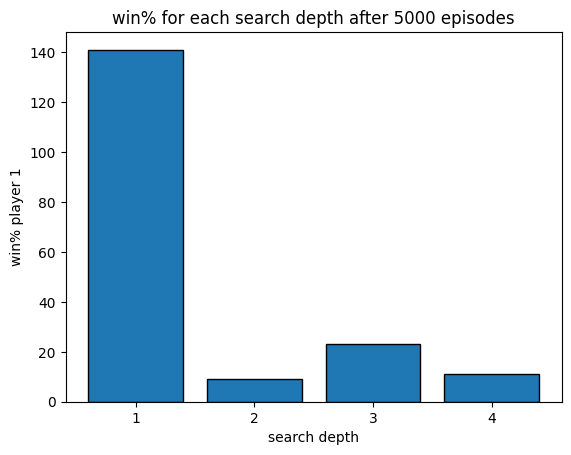

In [ ]:
import matplotlib.pyplot as plt


plt.bar(["1","2","3","4"], number_of_wins_Player1, edgecolor='black')

plt.xlabel('search depth')
plt.ylabel('win% player 1')
plt.title('win% for each search depth after 5000 episodes')
#plt.savefig('winsDepth.png')
plt.show()